In [1]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 23.3 MB/s eta 0:00:00


In [2]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.7 MB/s eta 0:00:00


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


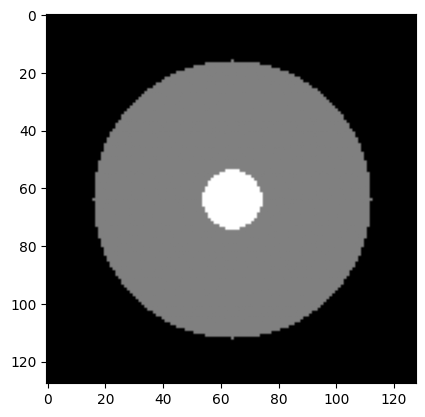

In [3]:
from matplotlib import pyplot as plt
import os
os.makedirs("phantom_dicom", exist_ok=True)

import numpy as np
import SimpleITK as sitk

# Volume dimensions (in voxels)
size = (128, 128, 128)
phantom = np.zeros(size, dtype=np.int16)

# Coordinates
x = np.arange(size[0]) - size[0]//2
y = np.arange(size[1]) - size[1]//2
z = np.arange(size[2]) - size[2]//2
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

# Head: large sphere
R_head = 50
mask_head = X**2 + Y**2 + Z**2 <= R_head**2
phantom[mask_head] = 100

# Parotid glands: smaller spheres inside
R_gland = 15
mask_left = (X+25)**2 + (Y)**2 + (Z)**2 <= R_gland**2
mask_right = (X-25)**2 + (Y)**2 + (Z)**2 <= R_gland**2
phantom[mask_left] = 200
phantom[mask_right] = 200

# Convert to SimpleITK image
image = sitk.GetImageFromArray(phantom)
image.SetSpacing([1.0, 1.0, 1.0])  # mm voxel spacing
image.SetOrigin([0.0, 0.0, 0.0])
print(phantom[128//2])
plt.imshow(phantom[50], cmap = plt.cm.gray)
plt.show()


In [4]:
import time
import sys
import os
import string, random  # <-- added for random PatientID generation
from pydicom.uid import generate_uid

def save_dcm(data_directory, path_to_save, image_3D):

   # if not series_IDs:
      #  print('ERROR: given directory "'+ data_directory+ '" does not contain a DICOM series.')
       # sys.exit(1)

    series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(data_directory)
    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(data_directory,series_IDs[0])
    #image_0 = generate_sitk_image(data_directory)
    series_reader = sitk.ImageSeriesReader()
    series_reader.SetFileNames(series_file_names)
    series_reader.MetaDataDictionaryArrayUpdateOn()
    series_reader.LoadPrivateTagsOn()
    image3D = series_reader.Execute()

    image_3D = sitk.GetImageFromArray(phantom)

    #writer.KeepOriginalImageUIDOn()

    filtered_image = image_3D

    tags_to_copy = [
        "0010|0020",  # Patient ID
        "0020|000D",  # Study Instance UID, for machine consumption
        "0020|0010",  # Study ID, for human consumption
        "0008|0020",  # Study Date
        "0008|0030",  # Study Time
        "0008|0050",  # Accession Number
    ]

    writer = sitk.ImageFileWriter()
# Use the study/series/frame of reference information given in the meta-data
# dictionary and not the automatically generated information from the file IO
    writer.KeepOriginalImageUIDOn()
    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

    # --- NEW: generate a fresh random PatientID (25-char alphanumeric) ---
    patient_id_random = ''.join(random.choices(string.ascii_uppercase + string.digits, k=25))

    series_tag_values = [
        (k, series_reader.GetMetaData(0, k.lower()))
        for k in tags_to_copy
        #if series_reader.HasMetaDataKey(0, k.lower())
    ] +  [
    ("0008|0060", "CT"),      # Modality
    ("0020|000e", "1.2.826.0.1.3680043.2.1125"),  # Series Instance UID
    ("0020|0011", "1"),       # Series Number
    ("0010|0010", "RESEARCH^PGphantom_CAMERON"),  # Patient Name
    ("0020|0052", '1.2.246.352.221.481990233581288636811206390483333082809') # Frame of Reference UID
] + [
        ("0008|0031", modification_time),  # Series Time
        ("0008|0021", modification_date),  # Series Date
        ("0008|0008", "DERIVED\\SECONDARY"),  # Image Type
        ("0020|000e","1.2.826.0.1.3680043.2.1125." + modification_date + ".1" + modification_time,),
    # Series Instance UID
    ("0020|0037","\\".join(map(str,(direction[0],direction[3],direction[6],direction[1],direction[4],direction[7],
),  # Image Orientation (Patient)
            )
        ),
    ),
    (
        "0008|103e",
        series_reader.GetMetaData(0, "0008|103e")
        if series_reader.HasMetaDataKey(0, "0008|103e")
        else "" + " Processed-SimpleITK",
    ),
    # --- NEW: override/set Patient ID with our random 25-char string ---
    ("0010|0020", patient_id_random),  # Patient ID
]

    number_digits = len(str(filtered_image.GetDepth()))
    for i in range(filtered_image.GetDepth()):
        digits = len(str(i))
        number_zeros = number_digits - digits

        image_slice = filtered_image[:, :, i]
        # Tags shared by the series.
        for tag, value in series_tag_values:
            image_slice.SetMetaData(tag, value)
        # Slice specific tags.
        #   Instance Creation Date
        image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d"))
        #   Instance Creation Time
        image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S"))
        #   Image Position (Patient)
        image_slice.SetMetaData(
            "0020|0032",
            "\\".join(map(str, filtered_image.TransformIndexToPhysicalPoint((0, 0, i)))),
        )
        #   Instance Number
        new_UID = generate_uid()
        image_slice.SetMetaData("0020|0013", str(i))
        image_slice.SetMetaData("0008|0018", new_UID)
        # Write to the output directory and add the extension dcm, to force writing
        # in DICOM format.

        print(new_UID)
        writer.SetFileName(os.path.join(path_to_save, "CT"+'.'+new_UID+".dcm"))
        writer.Execute(image_slice)
    print('===============================================')
    print("         DCM file saved into ",path_to_save)
    print('===============================================')

In [6]:
save_dcm("/content/TPS", "/content/phantom_try7", phantom)

1.2.826.0.1.3680043.8.498.47411255056415438337283827148286661403
1.2.826.0.1.3680043.8.498.38858966940183982190653742442926208620
1.2.826.0.1.3680043.8.498.10547239255283030567255377299822951464
1.2.826.0.1.3680043.8.498.50941030233114884294954445079659304519
1.2.826.0.1.3680043.8.498.90909462975703997214422863796201415984
1.2.826.0.1.3680043.8.498.27092568808356605352599268189880228023
1.2.826.0.1.3680043.8.498.11850710159337546777040371366027900009
1.2.826.0.1.3680043.8.498.71985081723002925444341861458895283354
1.2.826.0.1.3680043.8.498.22455756211755277279619931169887695361
1.2.826.0.1.3680043.8.498.72977753173009161056266591664907521507
1.2.826.0.1.3680043.8.498.74559141974442887760855830762038074941
1.2.826.0.1.3680043.8.498.53929234031142748551297226936187132071
1.2.826.0.1.3680043.8.498.27166453985463349044695176352199515267
1.2.826.0.1.3680043.8.498.72433812413867031667822449537960517135
1.2.826.0.1.3680043.8.498.54760858272461065821704806186513917881
1.2.826.0.1.3680043.8.498

In [7]:
import shutil

# Zip the folder
shutil.make_archive("phantom_try7", 'zip', "phantom_try7")
from google.colab import files
files.download("phantom_try7.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>